In [1]:
import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

# Import libraries

In [2]:
import geopandas as gpd
import pysal as ps
import psycopg2
import pandas as pd
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import mapclassify as mc
import seaborn as sns
import sklearn as sk
import shapely
%matplotlib inline

In [3]:
import os
os.chdir('...\\local_address')

# Import data 
* A postgresql database was created to store the data. To enable the database to handle the spatial data, PostGIS extension was added to the database. Shapefiles were added to the database using QGIS DB Manager tool. . Shapefiles can also be imported from a file directory using GeoPandas.read_file method. 
* Census and Road network shapefiles were downloaded from: www12.statcan.gc.ca 
* The road_network table contains all roads, streets, alleys, etc..., but only major highways indicated by ranks 1 and 2 were imported. 
* The csv file containing the location of EV stations were downloaded from: https://developer.nrel.gov/api/alt-fuel-stations 
* The population dataset (csv file) was was downloaded from https://www.statcan.gc.ca
* The income dataset (csv file) was also downloaded from https://www.statcan.gc.ca

## Census info

In [4]:
#creates a connection with postgresql  
con=psycopg2.connect(host="localhost",database="ev", user="username***", password="****")

In [5]:
# census id, census name, province name, and census polygon are imported from census table 
census=gpd.GeoDataFrame.from_postgis('SELECT cduid, cdname , prname, ST_Transform(geom,4326) AS geom FROM census',
                                     con, geom_col='geom')

In [6]:
census.head()

,cduid,cdname,prname,geom
0,4621,Division No. 21,Manitoba,"MULTIPOLYGON (((-98.98629 54.99338, -98.98689 ..."
1,4707,Division No. 7,Saskatchewan,"MULTIPOLYGON (((-107.23449 51.27132, -107.2344..."
2,4708,Division No. 8,Saskatchewan,"MULTIPOLYGON (((-109.64240 51.35882, -109.6423..."
3,4709,Division No. 9,Saskatchewan,"MULTIPOLYGON (((-103.16508 52.31865, -103.1583..."
4,4710,Division No. 10,Saskatchewan,"MULTIPOLYGON (((-103.27952 51.35715, -103.2795..."


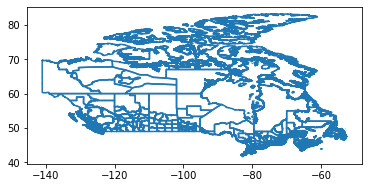

In [7]:
census.boundary.plot()

## Highway

In [8]:
sql_r="SELECT ST_Transform(geom, 4326) AS geom , prname_l, rank FROM road_network WHERE rank IN ('1','2')" 
highway=gpd.GeoDataFrame.from_postgis(sql_r,con, geom_col='geom')

In [9]:
highway.head()

,geom,prname_l,rank
0,"MULTILINESTRING ((-130.34492 54.29442, -130.34...",British Columbia / Colombie-Britannique,2
1,"MULTILINESTRING ((-113.53094 53.58060, -113.53...",Alberta,1
2,"MULTILINESTRING ((-73.62417 45.39798, -73.6242...",Quebec / Québec,2
3,"MULTILINESTRING ((-113.57793 53.51205, -113.57...",Alberta,2
4,"MULTILINESTRING ((-64.37439 45.91021, -64.3743...",New Brunswick / Nouveau-Brunswick,1


## EV stations

In [10]:
station=pd.read_csv('fuel_stations.csv')

In [11]:
station.head(2)

,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,Plus4,Station Phone,Status Code,...,EV Pricing,EV Pricing (French),LPG Nozzle Types,Hydrogen Pressures,Hydrogen Standards,CNG Fill Type Code,CNG PSI,CNG Vehicle Class,LNG Vehicle Class,EV On-Site Renewable Source
0,ELEC,Ramada,1319 2nd St W,NaN,Brooks,AB,T1R 1P7,NaN,403-362-6440,E,...,Free,Gratuit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ELEC,Davis Chevrolet,149 E Lake Crescent NE,NaN,Airdrie,AB,T4A 2H9,NaN,888-749-6505,E,...,Free,Gratuit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# creates a GeoDataFrame from a pandas DataFrame, and selects only two columns indicating the location (geometry) and province
station=gpd.GeoDataFrame(station, geometry=gpd.points_from_xy(x=station['Longitude'], y=station['Latitude']), crs='EPSG:4326')
station=station[['State','geometry']]

In [13]:
# deletes entries with invalid coordinates or null values
station.drop(station[station.geometry.x>0].index,axis=0, inplace=True)
station.drop(index=station[station['geometry'].x.isna()].index, inplace=True, axis=0)

In [14]:
station.head()

,State,geometry
0,AB,POINT (-111.89861 50.58524)
1,AB,POINT (-113.99828 51.28812)
2,AB,POINT (-113.49069 53.42135)
3,AB,POINT (-113.50725 53.51770)
4,AB,POINT (-114.04303 51.09286)


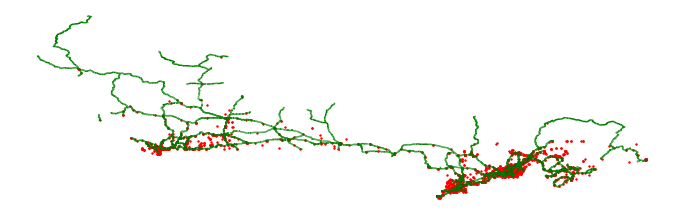

In [15]:
fig, axes=plt.subplots(figsize=(12,12))
station.plot(ax=axes, markersize=2, color='red')
highway.plot(ax=axes, color='green')
axes.set_axis_off()

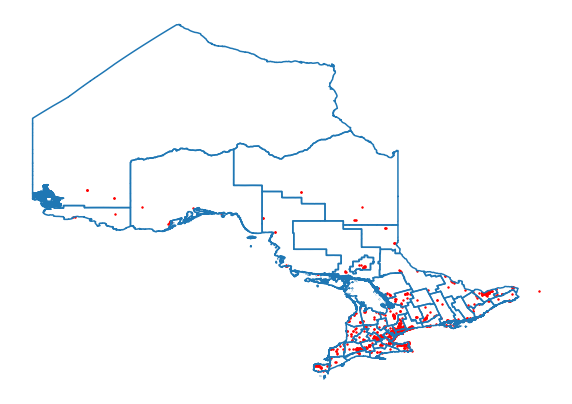

In [16]:
#plots the stations located in Ontario
fig, axes=plt.subplots(figsize=(10,10))
census[census['prname']=='Ontario'].boundary.plot( ax=axes)
station[station['State']=='ON'].plot(ax=axes, markersize=2, color='red')
axes.set_axis_off()

## Population data

In [17]:
df_pop=pd.read_csv('98-401-X2016060_English_CSV_data.csv',encoding = "ISO-8859-1")

In [18]:
# selects information for census id and population
df_pop=df_pop.loc[(df_pop['DIM: Profile of Census Divisions (2247)']=='Population, 2016'), ['GEO_CODE (POR)',
       'Dim: Sex (3): Member ID: [1]: Total - Sex']]

In [19]:
df_pop.rename(columns={'GEO_CODE (POR)':'cduid', 'Dim: Sex (3): Member ID: [1]: Total - Sex':'population'}, inplace=True)
# cduid must be a string to be consistent with other datasets
df_pop['cduid']=df_pop['cduid'].astype('str')

In [20]:
df_pop.head(2)

,cduid,population
0,1001,270348
2247,1002,20372


## Income data

In [21]:
df_income=pd.read_csv('98-402-X2016006-T1-CD-Eng.csv',encoding = "ISO-8859-1")

In [22]:
df_income=df_income.loc[df_income['Household type']=='Total \x96 Household type including census family structure',
                   ['Geographic code', 'Median household total income (2015 constant dollars), 2015']]

In [23]:
df_income.rename(columns={'Median household total income (2015 constant dollars), 2015':'income',
                         'Geographic code':'cduid'}, inplace=True)

df_income['cduid']=df_income['cduid'].astype('str')

In [24]:
df_income.head(2)

,cduid,income
0,1001,74676
9,1002,60912


# Counts of EV stations for each census

In [25]:
#counts the number of EV stations for each census using spatial join on census id field
df_count=gpd.sjoin(census[census['prname']=='Ontario'],station[station['State']=='ON'],
                 op='contains').dissolve(by='cduid',aggfunc='count')[['cdname']]

df_count.rename(columns={'cdname':'count'}, inplace=True)

In [26]:
df_count.head(2)

,count
cduid,
3501,9
3502,18


# Merging data to create a GeoDataFrame

In [27]:
# merging dataframes and geodataframes on the cduid column
gdf = reduce(lambda left,right: pd.merge(left,right,on=['cduid']), [census,df_income, df_pop, df_count])

In [28]:
gdf.head(2)

,cduid,cdname,prname,geom,income,population,count
0,3501,"Stormont, Dundas and Glengarry",Ontario,"MULTIPOLYGON (((-74.47130 45.40187, -74.47002 ...",59526,113429,9
1,3502,Prescott and Russell,Ontario,"MULTIPOLYGON (((-74.62539 45.63443, -74.62378 ...",78748,89333,18


# Plotting the data

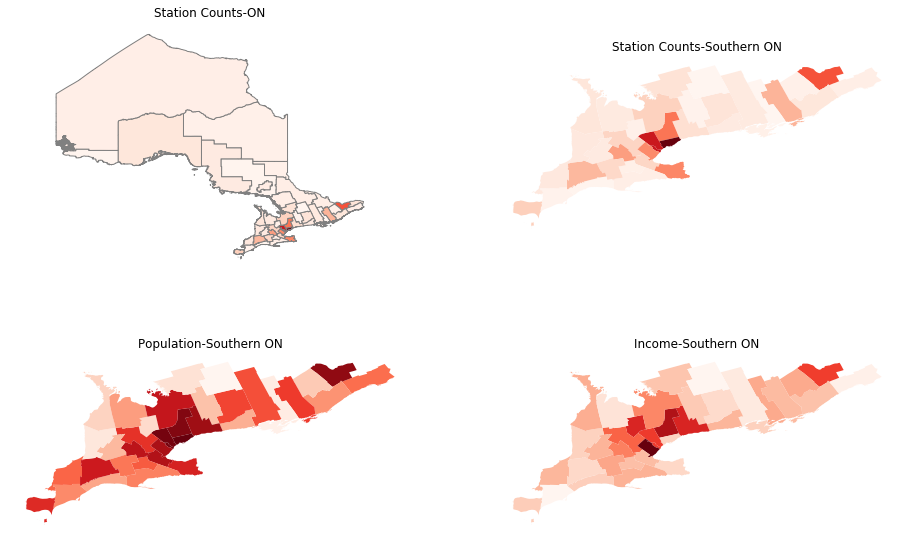

In [29]:
fig, axes= plt.subplots(2,2, figsize=(16,10))

axes[0,0].set_title('Station Counts-ON'); axes[0,0].set_axis_off()
gdf.plot(column='count',cmap='Reds', edgecolor='gray', ax=axes[0,0])


axes[0,1].set_title('Station Counts-Southern ON'); axes[0,1].set_axis_off()
gdf.cx[:,:45].plot(column='count', cmap='Reds', ax=axes[0,1])

axes[1,0].set_title('Population-Southern ON'); axes[1,0].set_axis_off()
gdf.cx[:,:45].plot(column='population', cmap='Reds', ax=axes[1,0])

axes[1,1].set_title('Income-Southern ON'); axes[1,1].set_axis_off()
gdf.cx[:,:45].plot(column='income', cmap='Reds', ax=axes[1,1])

# Spatial data analysis
* http://darribas.org/gds_scipy16/ipynb_md/04_esda.html
* The concept of spatial autocorrelation relates to the combination of two types of similarity: spatial similarity and attribute similarity.
* PySal library is used to calculate the Queen contigutiy weight, and identify hot and cold spots in terms of the number of charging stations in each census. Hot spot ndicates areas where there are higher number of stations compared to a random distribution. Cold spots, however, indicates areas where there are fewer number of stations.
* Censesus with a shared vertex between them are idicated as neighbors (i.e., geographically similar) by Queen weight (spatial weight).
* The spatial lag is a derived variable that measures the attribute similarity to pair up with the concept of spatial similarity.
* The quintile map of the spatial lag performs as a local smoother and tends to enhance the impression of value similarity in space. 

## Local spatial autocorrelation

In [30]:
from libpysal.weights import Queen
import libpysal
import esda
from esda.moran import Moran

In [31]:
# idVariable sets the qw index as cduid
qw=Queen.from_dataframe(gdf, geom_col='geom', idVariable='cduid') 
# qw must be transformed to calculate spatial lag
qw.transform='r' 

In [32]:
# calculates spatial lag for each census
gdf['spatial_lag']=libpysal.weights.lag_spatial(qw,gdf['count'])

* This map shows the similarity between the attribute (counts of EV stations in a sensus) in space. Higher spatial weight for a polygon indicates a greater similarity between that polygon and its neighbors. 

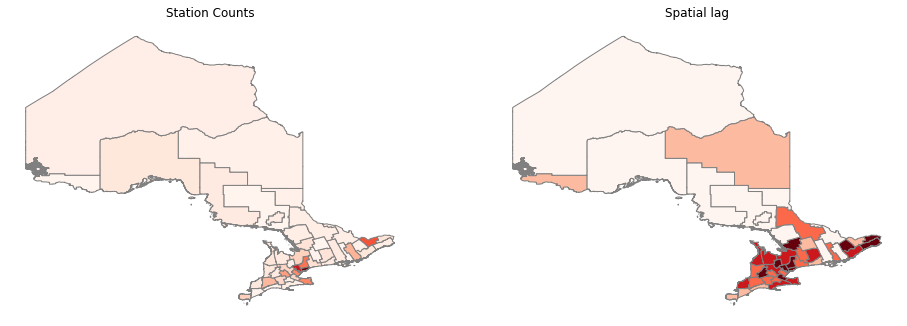

In [33]:
fig, axes= plt.subplots(1,2, figsize=(16,14))

axes[0].set_title('Station Counts'); axes[0].set_axis_off()
gdf.plot(column='count',cmap='Reds', edgecolor='gray', ax=axes[0])

axes[1].set_title('Spatial lag');
# color mapper
lag5=mc.Quantiles(gdf['spatial_lag'], k=5)
gdf.assign(cl=lag5.yb).plot(column='cl',cmap='Reds',edgecolor='gray', ax=axes[1])
axes[1].set_axis_off()

* The spatial lag is basically the weighted average of an attribute in the neighboring units. 
* Local spatial autocorrelation describes similarities or dissimilarities between a specific polygon with its neighboring polygons. The spatial autocorrelation is the correlation between attribute map and the spatial lag map. 
* Autocorrelation can be conceptualized using a Moran scatterplot. The x-axis is the attribute value (count of ev stations for each census), and the y-axis represents the spatial lag calculated for each census. Two dashed-line are the average values for the attribute and spatial lag values, and the red line is the best fit to the points (also known as global I). 
* We can distinguish the specific type of local spatial autocorrelation in High-High, Low-Low, High-Low, Low-High. Where the upper right quadrant displays HH, the lower left, LL, the upper left LH and the lower left HL. The upper left quadrant for example indicates that polygons with low values are surrounded by polygons with high values (LH). The lower right quadrant shows polygons with high values surrounded by neighbors with low values (HL).

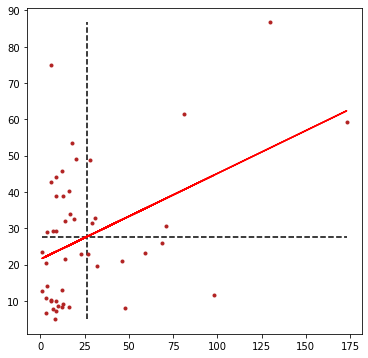

In [34]:
f, ax = plt.subplots(1, figsize=(6, 6))

plt.plot(gdf['count'], gdf['spatial_lag'], '.', color='firebrick')
plt.vlines(gdf['count'].mean(), gdf['spatial_lag'].min(), gdf['spatial_lag'].max(), linestyle='--')
plt.hlines(gdf['spatial_lag'].mean(), gdf['count'].min(), gdf['count'].max(), linestyle='--')

b, a = np.polyfit(gdf['count'], gdf['spatial_lag'], 1)
plt.plot(gdf['count'], a + b*gdf['count'], 'r')

## Global spatial autocorrelation

* Moran’s I measures the global spatial autocorrelation in an attribute measured over n spatial units. To answer the question whether a map is rondom or not, the values on the map are permuted and Moran's I is calculated. We reapeat this process say ten thousands timesto obtain the reference distribution under the null randomness. A simple way to visualize this distribution is to make a KDEplot, and add a rug showing all of the simulated points. The red line on the plot shows the observed Moran's I. The green line shows the average of I value for permuted maps.   

* I.sim gives the probability of the observed distribution happening if the null of randomness holds. So, given the low I.sim value, we can reject the null, and conclude that the map is not spatially random, but instead there is a signficant spatial association in distribution of EV station in Ontario's censuses. 


In [35]:
I=Moran(gdf['count'], qw)
print("Observed Moran's I value: {:.2}".format(I.I))
print("p value: {:0.2}".format(I.p_sim))

Observed Moran's I value: 0.24
p value: 0.015


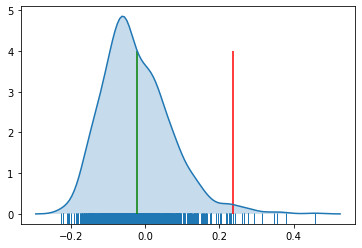

In [36]:
# The plot below shows a few of the permuted map had an I value greater than the observed I.
sns.kdeplot(I.sim, shade=True)
sns.rugplot(I.sim)
#plt.vlines(I.sim, 0, 0.5)
plt.vlines(I.I,0, 4, 'r')
plt.vlines(I.EI,0, 4, 'green')

## Local Moran
This time we are focused on individual polygon rather than considering all polygons. We calculate a local spatial autocorrelation for each polygon, and we reapeat that thousands of time by local data permutation. p_sim indicates whether the calculated local spatial autocorrelation is statistically significant or not. If the p value is less than 0.05, the local statistic is significant, that means there is a strong local autocorrelation for that polygon.   

In [37]:
# calculates local Moran
MoranL=esda.Moran_Local(gdf['count'], qw)

In [38]:
# selects only censuses with statistically significant local spatial autocorrelation (10 censuses)
sig= (MoranL.p_sim<0.05)
print('Number of censuses with significant local spatial autocorrelation:', sig.sum())

Number of censuses with significant local spatial autocorrelation: 10


In [39]:
# q=1 indicates the HH zone on the spatial lag crossplot (i.e. High value is surrounded by high values)
hotspots=MoranL.q==1 * sig

gdf[hotspots]

,cduid,cdname,prname,geom,income,population,count,spatial_lag
12,3519,York,Ontario,"MULTIPOLYGON (((-79.25061 44.45319, -79.25070 ...",95776,1.10991e+06,81,61.500000
13,3520,Toronto,Ontario,"MULTIPOLYGON (((-79.15202 43.81439, -79.15191 ...",65829,2.73157e+06,173,59.250000
14,3521,Peel,Ontario,"MULTIPOLYGON (((-79.70463 43.86366, -79.70338 ...",86233,1.38174e+06,130,86.666667


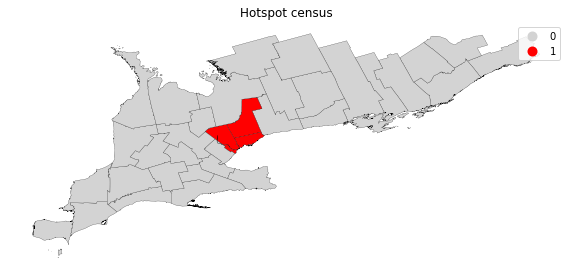

In [40]:
# convert boolean to 01 using *1
fig, axes= plt.subplots(1,1, figsize=(10,10))
hmap=colors.ListedColormap(['lightgrey','red'])
gdf.assign(cl=hotspots*1).cx[:,:45].plot(column='cl', cmap=hmap, categorical=True, legend=True,
                                            edgecolor='black', linewidth=0.2, ax=axes) 
axes.set_title('Hotspot census')
axes.set_axis_off()

In [41]:
# q=3 indicates the LL zone on the spatial lag crossplot (i.e. Low value is surrounded by low values)
coldspots=MoranL.q==3 * sig

gdf[coldspots]

,cduid,cdname,prname,geom,income,population,count,spatial_lag
7,3512,Hastings,Ontario,"MULTIPOLYGON (((-77.69017 45.43668, -77.68827 ...",61109,136445,13,9.000000
38,3549,Parry Sound,Ontario,"MULTIPOLYGON (((-79.36588 46.24145, -79.36298 ...",60251,42824,9,7.285714
39,3552,Sudbury,Ontario,"MULTIPOLYGON (((-81.85630 48.13079, -81.85689 ...",65333,21546,3,6.666667
40,3553,Greater Sudbury / Grand Sudbury,Ontario,"MULTIPOLYGON (((-80.81792 46.97276, -80.81849 ...",71791,161647,10,8.666667
43,3557,Algoma,Ontario,"MULTIPOLYGON (((-84.48261 49.47755, -84.48428 ...",58664,114094,12,8.400000
46,3560,Kenora,Ontario,"MULTIPOLYGON (((-88.86612 56.84777, -88.86838 ...",66198,65533,8,5.000000


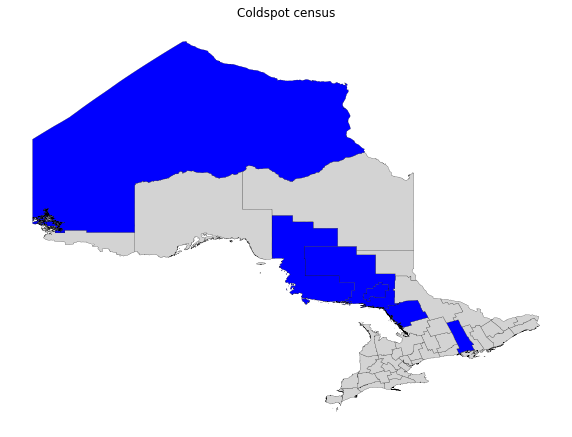

In [42]:
fig, axes= plt.subplots(1,1, figsize=(10,10))
hmap=colors.ListedColormap(['lightgrey', 'blue'])
gdf.assign(cl=coldspots*1).plot(figsize=(9,9), column='cl', cmap=hmap, edgecolor='black', linewidth=0.2, ax=axes)
axes.set_title('Coldspot census')
axes.set_axis_off()

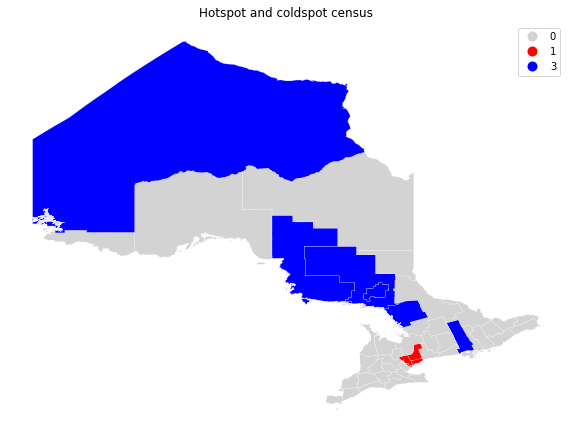

In [43]:
fig, axes= plt.subplots(1,1, figsize=(10,10))
hmap=colors.ListedColormap(['lightgrey', 'red', 'blue'])
gdf.assign(cl=hotspots*1+coldspots*3).plot(column='cl', cmap=hmap, edgecolor='white', linewidth=0.2, 
                                               categorical=True, legend=True,ax=axes )
axes.set_title('Hotspot and coldspot census')
axes.set_axis_off()

* York, Toronto, and Peel form a region with higher number of ev stations compared to other censuses in ON.

## spatial clustering
* Spatial clustering is similar to a regular clustering technique with one difference which is taking into account the spatial contiguity. Queen weights that were calculated before are used here to provide the contiguity information. The variable that used for clustering include: count, income, and population.

In [44]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

In [45]:
scaler=StandardScaler()

In [46]:
model=AgglomerativeClustering(linkage='ward', connectivity=qw.sparse,
                             n_clusters=4)
model.fit(scaler.fit_transform(gdf[['count', 'income','population']]))

AgglomerativeClustering(connectivity=<48x48 sparse matrix of type '<class 'numpy.float64'>'
	with 204 stored elements in Compressed Sparse Row format>,
                        n_clusters=4)

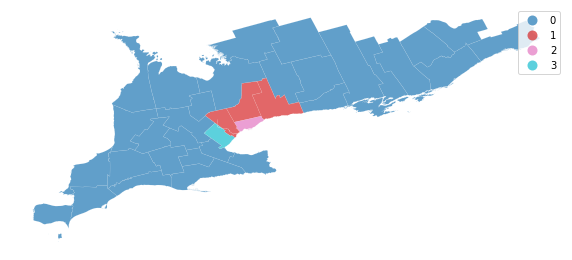

In [47]:
f, axes=plt.subplots(figsize=(10,10))
gdf.assign(cl=model.labels_).cx[:,:45].plot(column='cl', categorical=True, ax=axes, edgecolor='white', linewidth=0.1, 
                                        alpha=0.7, legend=True)
axes.set_axis_off()

# K-means clustering
* In kmeans method, only attributes are considered for clustering, without any spatial information.  

In [48]:
# finds the optimal number of cluster using elbow method
wcc=[]
for i in range (1,10):
    km=KMeans(n_clusters=i)
    km.fit(scaler.fit_transform(gdf[['count', 'income','population']]))
    wcc.append(km.inertia_)
    

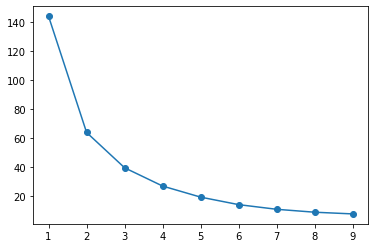

In [49]:
# 4 clusters 
plt.plot(range(1,10), wcc, marker='o')

In [50]:
cluster=KMeans(n_clusters=4).fit_predict(scaler.fit_transform(gdf[['count', 'income','population']]))
gdf['KM4Cluster']=cluster

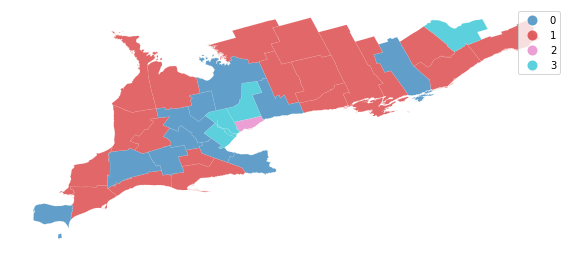

In [51]:
f, axes=plt.subplots(figsize=(10,10))
gdf.assign(cl=cluster).cx[:,:45].plot(column='cl', categorical=True, ax=axes, edgecolor='white', linewidth=0.1, 
                                        alpha=0.7, legend=True)
axes.set_axis_off()

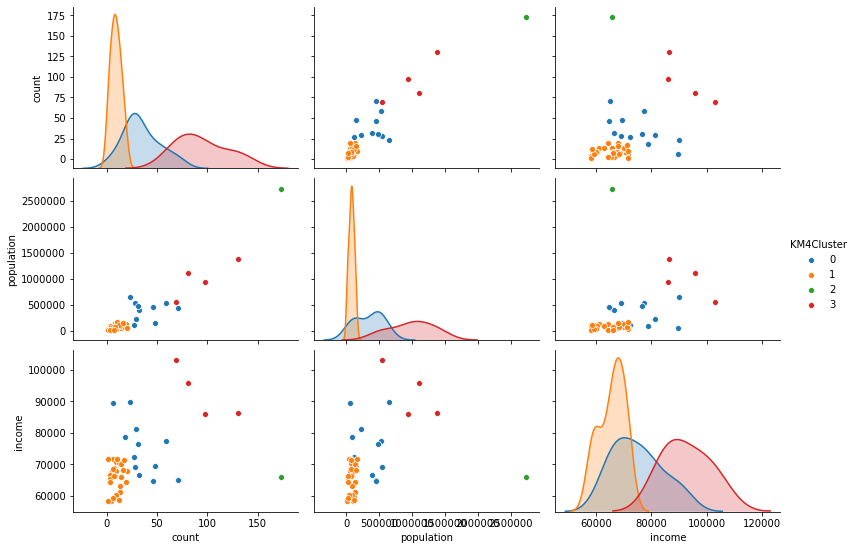

In [52]:
# distribution of ev stations, population, and income for each census
# cluster 2 (Toronto) has the highest number of ev stations, population and income. It's not shown on the kde plots, because
# it is the only one data in the cluster.
sns.pairplot(gdf, vars=['count','population','income'], hue='KM4Cluster', aspect=1.4)

# Interactive plotting
https://towardsdatascience.com/walkthrough-mapping-basics-with-bokeh-and-geopandas-in-python-43f40aa5b7e9

In [53]:
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, HoverTool
from bokeh.models import CategoricalColorMapper
from bokeh.palettes import Category10
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
tile_provider = get_provider(CARTODBPOSITRON)

In [54]:
# coordinate system transform and simplify the polygon for faster rendering
gdf_mercator=gdf.to_crs(epsg=3857)
gdf_mercator['geom']= gdf_mercator.simplify(tolerance=2000, preserve_topology= True)
gdf_mercator['KM4Cluster']=gdf_mercator['KM4Cluster'].astype('str')

In [55]:
# converts geopandas to geojson format as required by bokeh
merged_json = json.loads(gdf_mercator.to_json())
json_data = json.dumps(merged_json)
geosource = GeoJSONDataSource(geojson = json_data)

In [56]:
# creates a colormap, hover info to be shown on the plot, and generates the plot
cl_map=CategoricalColorMapper(factors=['1', '2','0','3'], palette=Category10[4])
hover = HoverTool(tooltips = [ ('cdname','@cdname'),('count','@count'),('population','@population'),('income','@income')])

p = figure(title = 'Share',tools = [hover,"pan,wheel_zoom,box_zoom,reset"])

#p.add_tile(tile_provider)

p.patches('xs','ys', source = geosource, 
           fill_color = {'field' :'KM4Cluster', 'transform' : cl_map}, alpha=0.9, line_color = 'white', line_width = 0.25)


GlyphRenderer(id='1038', ...)

In [57]:
output_notebook()
show(p)

Loading BokehJS ...